## An Introduction to Q-Learning: A Tutorial For Beginners
https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial

### Q-learning algorithm
<img src="images/Q_Learning_Process_134331efc1.jpg" alt="Q_Learning_Process"/>

In this section, we will build our Q-learning model from scratch using the Gym environment, Pygame, and Numpy. The Python tutorial is a modified version of the Notebook by Thomas Simonini. It includes initializing the environment and Q-Table, defining greedy policy, setting hyperparameters, creating and running the training loop and evaluation, and visualizing the results.

In [1]:
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 38 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additio

In [2]:
!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install imageio imageio_ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.4/694.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790675 sha256=1e4c200bb055ee553e1429fa7096bd8766fea28d054ebbce5717e1c02a32706e
  Stored in directory: /root/.cache/pip/wheels/2f/a1/b1/5f4110c8943b36e6cdfcc0e5768481639fa042b3c8357e82cc
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [3]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

### Frozen Lake Gym Environment
We are going to create a non-slippery 4x4 environment using the Frozen Lake gym library.

There are two grid versions, “4x4” and “8x8”.
If the `is_slippery=True`, the agent may not move in the intended direction due to the slippery nature of the frozen lake.
After initializing the environment, we will do an environmental analysis.

In [4]:
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # display a random observation

Observation Space Discrete(16)
Sample observation 0


Let’s discover the number of actions and display the random action.

**The action space:**

- 0: move left
- 1: move down
- 2: move right
- 3: move up

**Reward function:**

- Reaching the goal: +1
- Falling into the hole: 0
- Staying on the frozen lake: 0

In [5]:
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 4
Action Space Sample 2


### Create and Initialize the Q-table
The Q-Table has columns as actions, and rows as states. We can use OpenAI Gym to find action space and state space. We will then use this information to create the Q-Table.

In [6]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [7]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

### Epsilon-greedy policy
In the previous section, we have learned about the epsilon greedy strategy that handles exploration and exploitation tradeoffs. With a Probability of 1 - ɛ, we do exploitation, and with the probability ɛ, we do exploration.

In the epsilon_greedy_policy we will:

1. Generate the random number between 0 to 1.
2. If the random number is greater than epsilon, we will do exploitation. It means that the agent will take the action with the highest value given a state.
3. Else, we will do exploration (Taking random action).

In [8]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

### Define the greedy policy
As we now know that Q-learning is an off-policy algorithm which means that the policy of taking action and updating function is different.

In this example, the Epsilon Greedy policy is acting policy, and the Greedy policy is updating policy.

The Greedy policy will also be the final policy when the agent is trained. It is used to select the highest state and action value from the Q-Table.

In [9]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

### Model hyperparameters
These hyperparameters are used in the training loop, and fine-tuning them will give you better results.

The Agent needs to explore enough state space to learn good value approximation; we need to have progressive decay of epsilon. If the decay rate is high, the agent might get stuck as it has not explored enough state space.

- There are 10,000 training and 100 evaluation episodes.
- The learning rate is 0.7.
- We are using "FrozenLake-v1" as an environment with 99 maximum steps per episode.
- The gamma (discount rate) is 0.95.
- eval_seed: evaluation seed for the environment.
- The exploration epsilon probability at the start is 1.0, and the minimum probability will be 0.05.
- The exponential decay rate for epsilon probability is 0.0005.

In [10]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.7

# Evaluation parameters
n_eval_episodes = 100

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 99
gamma = 0.95
eval_seed = []

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

Model Training
In the training loop, we will:

1. Create a loop for training episodes.
2. We will first reduce epsilon. As we need less and less exploration and more exploitation with every episode.
3. Reset the environment.
4. Create a nested loop for the maximum steps.
5. Choose the action using the epsilon greedy policy.
6. Take action (At) and observe the expected reward(Rt+1) and state(St+1).
7. Take the action (a) and observe the outcome state(s') and reward (r).
8. Update the Q-function using the formula.
9. If `done= True`, finish the episode and break the loop.
10. Finally, change the current state to a new state.
11. After completing all of the training episodes, the function will return the updated Q-Table.

In [11]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):

    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):

      action = epsilon_greedy_policy(Qtable, state, epsilon)


      new_state, reward, done, info = env.step(action)


      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break

      # Our state is the new state
      state = new_state
  return Qtable

In [12]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)
Qtable_frozenlake

  0%|          | 0/10000 [00:00<?, ?it/s]

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

### Evaluation
The evaluate_agent runs for `n_eval_episodes` episodes and returns the mean and standard deviation of the reward.

1. In the loop, we will first check if there is an evaluation seed. If not, then we will reset the environment without seed.
2. The nested loop will run to max_steps.
3. The agent will take the action that has the maximum expected future reward in a given state using Q-Table.
4. Calculate the reward.
5. Change the state.
6. If done (agent falls into the hole or goal has been achieved), break the loop.
7. Append the results.
8. In the end, we will use these results to calculate the mean and standard deviation.

In [13]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum reward
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [14]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


### Visualizing the result
Till now, we have been playing with numbers, and to give the demo, we need to create an animated Gif of the agent from the start till it reaches the goal.

1. We will first create the state by resetting the environment with a random integer 0-500.
2. Render the environment using rdb_array to create an image array.
3. Then append the `img` to the `images` array.
4. In the loop, we will take the step using the Q-Table and render the image for every step.
5. In the end, we will use this array and imageio to create a Gif of one frame per second.

In [15]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


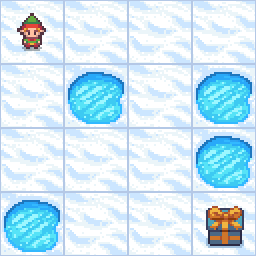

In [16]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')